<a href="https://colab.research.google.com/github/pranavsrinivas29/Hyperparamter-Optimization/blob/main/Hyp_Opt_Regression_(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimisation
## Task: Regression
### Methods used: Grid Search, Random Search, Bayesian Search,Gradient Based Search


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from datetime import datetime
from sklearn.base import BaseEstimator
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

import time
import warnings
warnings.filterwarnings('ignore')

np.version.version

'1.25.2'

## Data Preparation

In [ ]:
# Retrieve stock market data
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'

data = yf.download(stock_symbol, start=start_date, end=end_date)

# Extract and preprocess the data
data = data[['Close']]
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

def create_time_series_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 10

X_train, y_train = create_time_series_data(train_data['Close'].values, look_back)
X_test, y_test = create_time_series_data(test_data['Close'].values, look_back)

[*********************100%%**********************]  1 of 1 completed


## Baseline Model

In [ ]:
def build_baseline_lstm_model():
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=(look_back, 1), activation='relu'),
        keras.layers.Dense(1)])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

In [ ]:
keras.utils.set_random_seed(42)

baseline_start_time = time.time()

baseline_model = build_baseline_lstm_model()
baseline_model.fit(X_train, y_train, epochs=10, verbose=0)

baseline_end_time = time.time()
baseline_time = baseline_end_time - baseline_start_time

train_predict_baseline = baseline_model.predict(X_train)
test_predict_baseline = baseline_model.predict(X_test)
test_rmse_baseline = np.sqrt(mean_squared_error(y_test, test_predict_baseline))
r2_test_baseline = r2_score(y_test, test_predict_baseline)

print("\n")
print('Baseline LSTM model')
print('Test RMSE: {:.4f}'.format(test_rmse_baseline))
print('Test R2: {:.4f}'.format(r2_test_baseline))
print("\n")
print("Training time for baseline model:", baseline_end_time - baseline_start_time, "seconds")

5/5 [==============================] - 0s 6ms/step


Baseline LSTM model
Test RMSE: 0.0440
Test R2: 0.7452


Training time for baseline model: 10.191827297210693 seconds


# Code for Optimization Performance Measurement

We Use 3 Hyperparameters for Optimization Performance Measurement:
- Number of Units in Hidden Layer
- Dropout Rate
- Learning Rate

## Grid, Random and Bayesian Model Definition

In [ ]:
def traditional_optimisation_model(units, dropout, learning_rate):
    model = keras.Sequential([
        keras.layers.LSTM(units, input_shape=(look_back, 1), activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

class LSTMRegressor(BaseEstimator):
    def __init__(self, units=64, dropout=0.2, learning_rate=0.01, epochs=10, batch_size=32):
        self.units = units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        model = traditional_optimisation_model(self.units, self.dropout, self.learning_rate)
        model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        self.model = model

    def predict(self, X):
        return self.model.predict(X, verbose=0)


## Grid Search

In [ ]:
param_grid = {
    'units': [32, 64, 128, 256],
    'dropout': [0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid_start_time = time .time()
grid_search = GridSearchCV(LSTMRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
grid_end_time = time.time()

grid_search_time = grid_end_time - grid_start_time

In [ ]:
best_params_grid = grid_search.best_params_
optimized_model_grid = traditional_optimisation_model(**best_params_grid)
optimized_model_grid.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

train_predict_grid = optimized_model_grid.predict(X_train)
test_predict_grid = optimized_model_grid.predict(X_test)
test_rmse_grid = np.sqrt(mean_squared_error(y_test, test_predict_grid))
r2_test_grid = r2_score(y_test, test_predict_grid)

hyperparameters_history_grid = grid_search.cv_results_['params']
hyperparameter_names_grid = list(hyperparameters_history_grid[0].keys())
mse_values_grid = -grid_search.cv_results_['mean_test_score']

print("\n")
print('Best LSTM model with Grid Search')
print('Test RMSE: {:.4f}'.format(test_rmse_grid))
print('Test R2: {:.4f}'.format(r2_test_grid))

5/5 [==============================] - 0s 4ms/step


Best LSTM model with Grid Search
Test RMSE: 0.0427
Test R2: 0.7601


In [ ]:
grid_search_time

569.4767305850983



Best Hyperparameters:
Units: 64
Dropout: 0
Learning Rate: 0.01


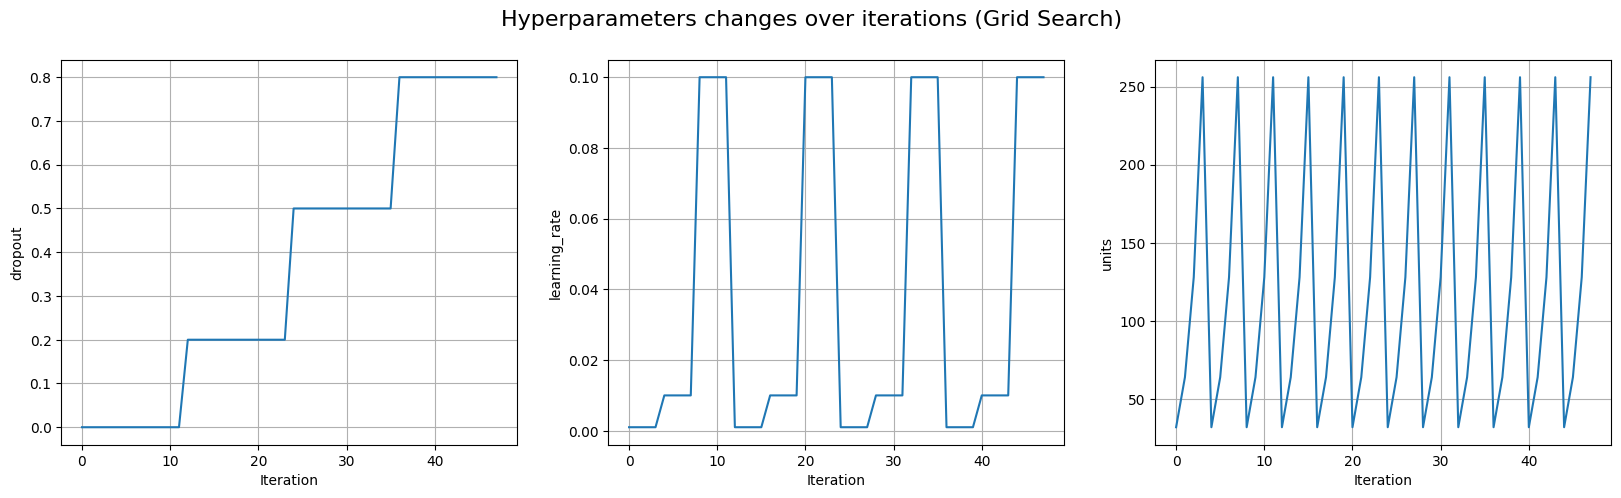

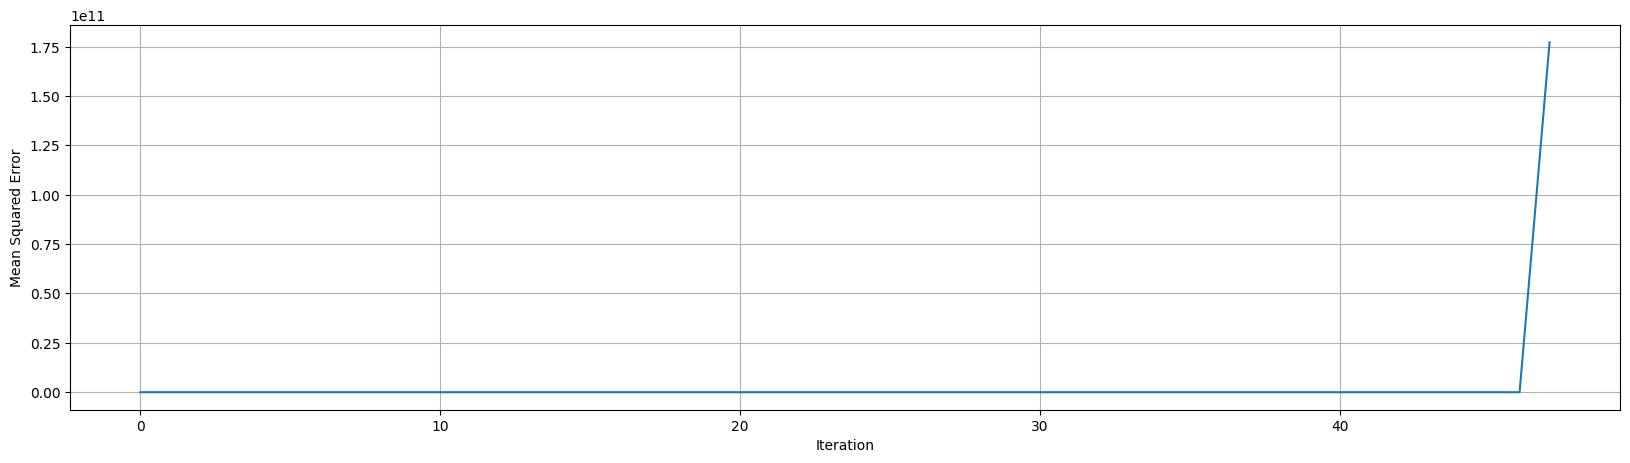

In [ ]:
print("\n")
print('Best Hyperparameters:')
print('Units: {}'.format(best_params_grid['units']))
print('Dropout: {}'.format(best_params_grid['dropout']))
print('Learning Rate: {}'.format(best_params_grid['learning_rate']))

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hyperparameters changes over iterations (Grid Search)', fontsize=16)
for i in range(len(hyperparameter_names_grid)):
    x_axis = [x[hyperparameter_names_grid[i]] for x in hyperparameters_history_grid]
    ax[i].plot(x_axis)
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel(hyperparameter_names_grid[i])
    ax[i].grid()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(mse_values_grid)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.show()

In [ ]:
print(hyperparameters_history_grid)
mse_values_grid_rounded = [round(value, 4) for value in mse_values_grid]
print(mse_values_grid_rounded)


[{'dropout': 0, 'learning_rate': 0.001, 'units': 32}, {'dropout': 0, 'learning_rate': 0.001, 'units': 64}, {'dropout': 0, 'learning_rate': 0.001, 'units': 128}, {'dropout': 0, 'learning_rate': 0.001, 'units': 256}, {'dropout': 0, 'learning_rate': 0.01, 'units': 32}, {'dropout': 0, 'learning_rate': 0.01, 'units': 64}, {'dropout': 0, 'learning_rate': 0.01, 'units': 128}, {'dropout': 0, 'learning_rate': 0.01, 'units': 256}, {'dropout': 0, 'learning_rate': 0.1, 'units': 32}, {'dropout': 0, 'learning_rate': 0.1, 'units': 64}, {'dropout': 0, 'learning_rate': 0.1, 'units': 128}, {'dropout': 0, 'learning_rate': 0.1, 'units': 256}, {'dropout': 0.2, 'learning_rate': 0.001, 'units': 32}, {'dropout': 0.2, 'learning_rate': 0.001, 'units': 64}, {'dropout': 0.2, 'learning_rate': 0.001, 'units': 128}, {'dropout': 0.2, 'learning_rate': 0.001, 'units': 256}, {'dropout': 0.2, 'learning_rate': 0.01, 'units': 32}, {'dropout': 0.2, 'learning_rate': 0.01, 'units': 64}, {'dropout': 0.2, 'learning_rate': 0.01,

## Random Search

In [ ]:
hyperparameters_history_random = []
mse_history_random = []

param_distributions = {
    'units': [32, 64, 128, 256],
    'dropout': [0, 0.2, 0.5, 0.8],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

random_start_time = time.time()
random_search = RandomizedSearchCV(LSTMRegressor(), param_distributions, cv=3, scoring='neg_mean_squared_error', verbose=0)
random_search.fit(X_train, y_train)
random_end_time = time.time()

random_search_time = random_end_time - random_start_time

In [ ]:
random_search_time

89.36149001121521

In [ ]:
keras.utils.set_random_seed(42)

best_params_random = random_search.best_params_
optimized_model_random = traditional_optimisation_model(**best_params_random)
optimized_model_random.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

train_predict_random = optimized_model_random.predict(X_train)
test_predict_random = optimized_model_random.predict(X_test)

train_rmse_random = np.sqrt(mean_squared_error(y_train, train_predict_random))
test_rmse_random = np.sqrt(mean_squared_error(y_test, test_predict_random))
r2_train_random = r2_score(y_train, train_predict_random)
r2_test_random = r2_score(y_test, test_predict_random)

hyperparameters_history_random = random_search.cv_results_['params']
hyperparameter_names_random = list(hyperparameters_history_random[0].keys())
mse_values_random = -random_search.cv_results_['mean_test_score']

print("\n")
print('Best LSTM model with Random Search')
print('Test RMSE: {:.4f}'.format(test_rmse_random))
print('Test R2: {:.4f}'.format(r2_test_random))

print("\n")
print('Best Hyperparameters:')
print('Units: {}'.format(best_params_random['units']))
print('Dropout: {}'.format(best_params_random['dropout']))
print('Learning Rate: {}'.format(best_params_random['learning_rate']))

5/5 [==============================] - 0s 5ms/step


Best LSTM model with Random Search
Test RMSE: 0.0491
Test R2: 0.6830


Best Hyperparameters:
Units: 64
Dropout: 0.2
Learning Rate: 0.01


In [ ]:
print(hyperparameters_history_random)
print(mse_values_random)

[{'units': 32, 'learning_rate': 0.001, 'dropout': 0.8}, {'units': 128, 'learning_rate': 0.01, 'dropout': 0.8}, {'units': 32, 'learning_rate': 0.0001, 'dropout': 0}, {'units': 32, 'learning_rate': 0.1, 'dropout': 0.5}, {'units': 64, 'learning_rate': 0.001, 'dropout': 0}, {'units': 32, 'learning_rate': 0.001, 'dropout': 0.5}, {'units': 32, 'learning_rate': 0.0001, 'dropout': 0.2}, {'units': 32, 'learning_rate': 0.1, 'dropout': 0}, {'units': 64, 'learning_rate': 0.01, 'dropout': 0.2}, {'units': 64, 'learning_rate': 0.1, 'dropout': 0.8}]
[0.03497595 0.03829742 0.37885814 0.09309211 0.00373713 0.00580122
 0.25517739 0.01658478 0.00421265 0.31556562]


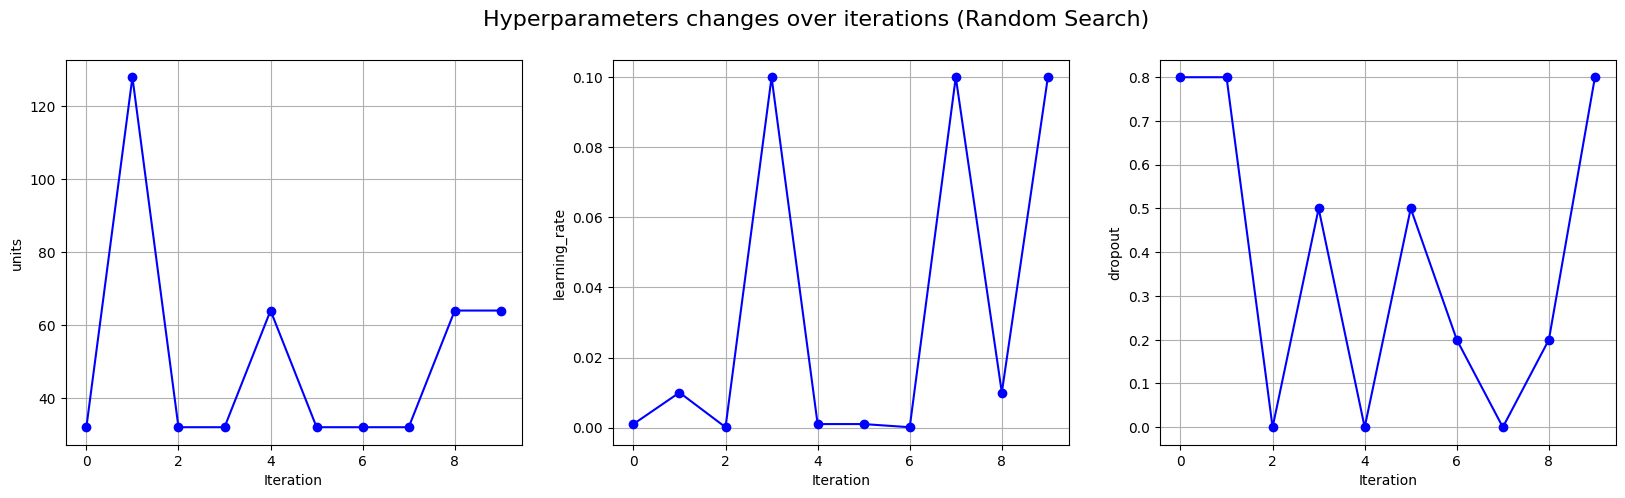

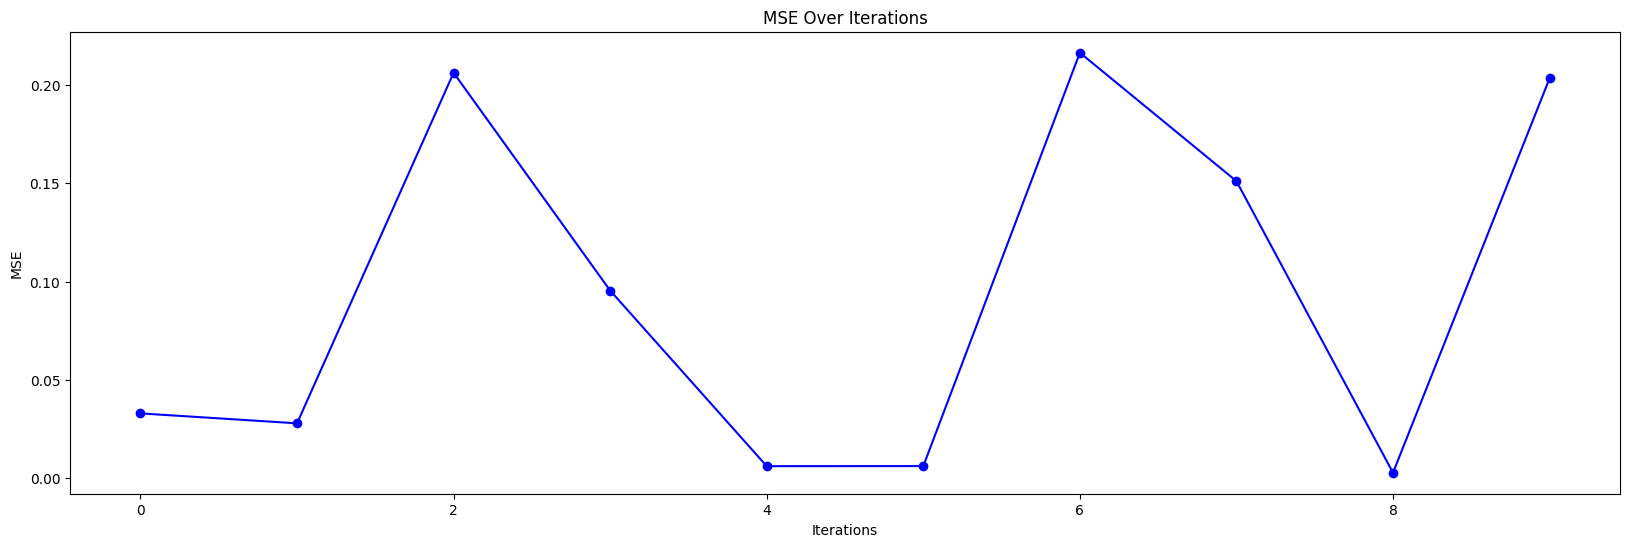

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hyperparameters changes over iterations (Random Search)', fontsize=16)
for i in range(len(hyperparameter_names_random)):
    x_axis = [x[hyperparameter_names_random[i]] for x in hyperparameters_history_random]
    ax[i].plot(x_axis, marker='o', linestyle='-', color='b')
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel(hyperparameter_names_random[i], )
    ax[i].grid()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(range(len(mse_values_random)), mse_values_random, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE Over Iterations')
plt.show()

## Bayesian Optimisation

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer
from skopt.space import Real, Integer

In [ ]:
param_space = {
    'units': Integer(32, 256),
    'dropout': Real(0, 0.8),
    'learning_rate': Real(0.001, 0.1)
}

# Initialize BayesSearchCV
bayes_search_sk = BayesSearchCV(
    LSTMRegressor(),
    param_space,
    random_state=42,
    scoring='neg_mean_squared_error',
    cv=3
)

start_time_bayssk = time.time()
bayes_search_sk.fit(X_train, y_train)
end_time_bayssk = time.time()

bayesian_opt_time_sk = end_time_bayssk - start_time_bayssk

In [ ]:
best_hyperparameters_bayssk = bayes_search_sk.best_params_
best_units = best_hyperparameters_bayssk['units']
best_dropout = best_hyperparameters_bayssk['dropout']
best_learning_rate = best_hyperparameters_bayssk['learning_rate']

best_model = traditional_optimisation_model(best_units, best_dropout, best_learning_rate)
best_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

test_rmse_sk = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test_bayes_sk = r2_score(y_test, y_pred_test)

hyperparameters_history_bayesian_sk = []
mse_history_bayesian_sk = []

results_bayesian_sk = bayes_search_sk.cv_results_
param_names_bayesian_sk = list(param_space.keys())

for i, params in enumerate(results_bayesian_sk['params']):
    hyperparameters = [params[param_name] for param_name in param_names_bayesian_sk]
    mts = results_bayesian_sk['mean_test_score'][i]
    hyperparameters_history_bayesian_sk.append(hyperparameters)
    mse_history_bayesian_sk.append(-mts)

print('Best LSTM model with Bayesian Optimization (using skopt)')
print('Test RMSE: {:.4f}'.format(test_rmse_sk))
print('Test R2: {:.4f}'.format(r2_test_bayes_sk))
print("\n")
print('Best Hyperparameters:')
print('Units: {}'.format(best_units))
print('Dropout: {}'.format(best_dropout))
print('Learning Rate: {}'.format(best_learning_rate))

5/5 [==============================] - 0s 19ms/step
Best LSTM model with Bayesian Optimization (using skopt)
Test RMSE: 0.0371
Test R2: 0.8187


Best Hyperparameters:
Units: 146
Dropout: 0.0
Learning Rate: 0.012145476579519102


In [ ]:
bayesian_opt_time_sk

678.9849112033844

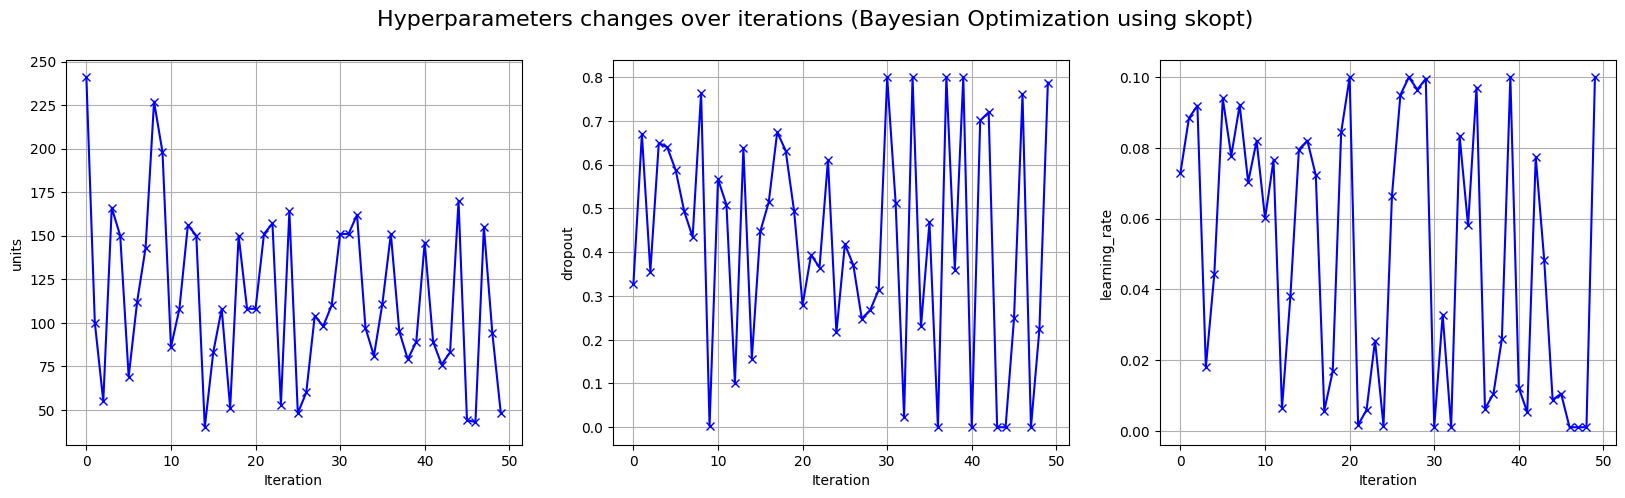

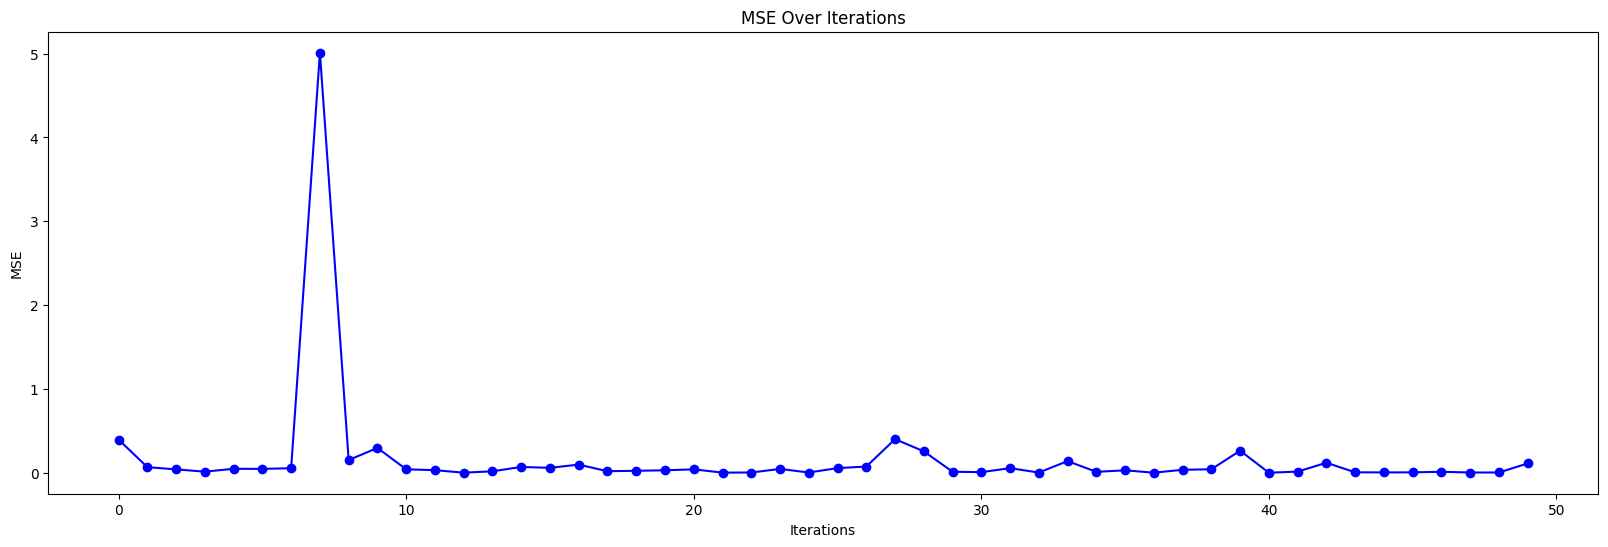

In [ ]:
hyperparameters_history_bayesian_sk = np.array(hyperparameters_history_bayesian_sk)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hyperparameters changes over iterations (Bayesian Optimization using skopt)', fontsize=16)
for i in range(len(param_names_bayesian_sk)):
    x_axis = hyperparameters_history_bayesian_sk[:, i]
    ax[i].plot(x_axis, marker='x', color='b')
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel(param_names_bayesian_sk[i])
    ax[i].grid()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(range(len(mse_history_bayesian_sk)), mse_history_bayesian_sk, marker='o', color='b')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE Over Iterations')
plt.show()

In [ ]:
print(hyperparameters_history_bayesian_sk)
print(mse_history_bayesian_sk)

[[2.41000000e+02 3.28083167e-01 7.30448486e-02]
 [1.00000000e+02 6.69910684e-01 8.84482125e-02]
 [5.50000000e+01 3.55866010e-01 9.19535296e-02]
 [1.66000000e+02 6.49916791e-01 1.80152846e-02]
 [1.50000000e+02 6.39642753e-01 4.43648895e-02]
 [6.90000000e+01 5.87222414e-01 9.39976040e-02]
 [1.12000000e+02 4.93663487e-01 7.77610735e-02]
 [1.43000000e+02 4.34722454e-01 9.20809134e-02]
 [2.27000000e+02 7.64382389e-01 7.03615230e-02]
 [1.98000000e+02 2.90424580e-03 8.19651719e-02]
 [8.60000000e+01 5.66891367e-01 6.00627960e-02]
 [1.08000000e+02 5.08178440e-01 7.65503233e-02]
 [1.56000000e+02 1.00149196e-01 6.37979760e-03]
 [1.50000000e+02 6.38016203e-01 3.82566345e-02]
 [4.00000000e+01 1.56964002e-01 7.95272808e-02]
 [8.30000000e+01 4.47568902e-01 8.20746219e-02]
 [1.08000000e+02 5.14775920e-01 7.22040006e-02]
 [5.10000000e+01 6.74580414e-01 5.68353674e-03]
 [1.50000000e+02 6.32221383e-01 1.68330882e-02]
 [1.08000000e+02 4.93415221e-01 8.45046822e-02]
 [1.08000000e+02 2.79295783e-01 1.000000

## Gradient Based Optimisation

#### Objective Function Definition

In [ ]:
hyperparameters_history_scipy = []
mse_values_history_scipy = []

def lstm_model(units, dropout, learning_rate):
    model = Sequential([
        LSTM(units, input_shape=(look_back, 1), activation='relu'),
        Dropout(dropout),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

def objective_function(params):
    units, dropout, learning_rate = params
    units = int(round(units))

    # Add early stopping for the regression model
    early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=0, mode='auto', restore_best_weights=True)

    start_time_scipy = time.time()
    model = lstm_model(units, dropout, learning_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, callbacks=[early_stopping])
    end_time_scipy = time.time()

    training_time_scipy = end_time_scipy - start_time_scipy

    test_predict = model.predict(X_test, verbose=0)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

    hyperparameters_history_scipy.append(params)
    mse_values_history_scipy.append(test_rmse)
    print(f"Iteration: {len(mse_values_history_scipy)}, Hyperparameters: {params}, RMSE: {test_rmse}, Training Time: {training_time_scipy}")
    return test_rmse


#### Performing Gradient Based Optimisation

In [ ]:
initial_params = [round(np.random.uniform(32, 256), 4), round(np.random.uniform(0, 0.8), 4), round(np.random.uniform(0.001, 0.1), 4)]
print('Initial Parameters:', initial_params)

Initial Parameters: [254.6278, 0.1065, 0.0164]


In [ ]:

bounds = [(32, 256), (0, 0.8), (0.001, 0.1)]

minimize_start_time = time.time()
result = minimize(objective_function, initial_params, method='L-BFGS-B',
                  options={'disp': True}, bounds=bounds)

minimize_end_time = time.time()

minimize_time = minimize_end_time - minimize_start_time

Iteration: 1, Hyperparameters: [2.546278e+02 1.065000e-01 1.640000e-02], RMSE: 0.05812765456807996, Training Time: 11.684354066848755
Iteration: 2, Hyperparameters: [2.546278e+02 1.065000e-01 1.640000e-02], RMSE: 0.04661411078128675, Training Time: 7.258835792541504
Iteration: 3, Hyperparameters: [2.5462780e+02 1.0650001e-01 1.6400000e-02], RMSE: 0.048552866041887875, Training Time: 6.125934839248657
Iteration: 4, Hyperparameters: [2.546278e+02 1.065000e-01 1.640001e-02], RMSE: 0.04320130686001079, Training Time: 7.197572946548462
Iteration: 5, Hyperparameters: [2.56e+02 8.00e-01 1.00e-01], RMSE: 4.2474126517464486, Training Time: 5.023360967636108
Iteration: 6, Hyperparameters: [2.56e+02 8.00e-01 1.00e-01], RMSE: 33.906890407487026, Training Time: 8.267290830612183
Iteration: 7, Hyperparameters: [2.5600000e+02 7.9999999e-01 1.0000000e-01], RMSE: 4.349718700355354, Training Time: 6.567996978759766
Iteration: 8, Hyperparameters: [2.560000e+02 8.000000e-01 9.999999e-02], RMSE: 1.56889405

In [ ]:
best_params_scipy = result.x
best_units_scipy, best_dropout_scipy, best_learning_rate_scipy = best_params_scipy
best_units_scipy = int(round(best_units_scipy))

optimized_model_scipy = lstm_model(best_units_scipy, best_dropout_scipy, best_learning_rate_scipy)
optimized_model_scipy.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

train_predict_scipy = optimized_model_scipy.predict(X_train)
test_predict_scipy = optimized_model_scipy.predict(X_test)

test_rmse_scipy = np.sqrt(mean_squared_error(y_test, test_predict_scipy))
r2_train_scipy = r2_score(y_train, train_predict_scipy)
r2_test_scipy = r2_score(y_test, test_predict_scipy)

# Print model statistics and plot the predictions vs. actual values for the best model
print("\n")
print('Best LSTM model')
print('Test RMSE: {:.4f}'.format(test_rmse_scipy))
print('Train R2: {:.4f}'.format(r2_train_scipy))
print('Test R2: {:.4f}'.format(r2_test_scipy))

# Print the best hyperparameters with a space between each hyperparameter and output above and below
print("\n")
print('Best Hyperparameters:')
print('Units: {}'.format(int(best_units_scipy)))
print('Dropout: {}'.format(round(best_dropout_scipy, 4)))
print('Learning Rate: {}'.format(best_learning_rate_scipy))


5/5 [==============================] - 0s 10ms/step


Best LSTM model
Test RMSE: 0.0489
Train R2: 0.9733
Test R2: 0.6845


Best Hyperparameters:
Units: 255
Dropout: 0.1065
Learning Rate: 0.01640003507991764


In [ ]:
minimize_time

582.9156424999237

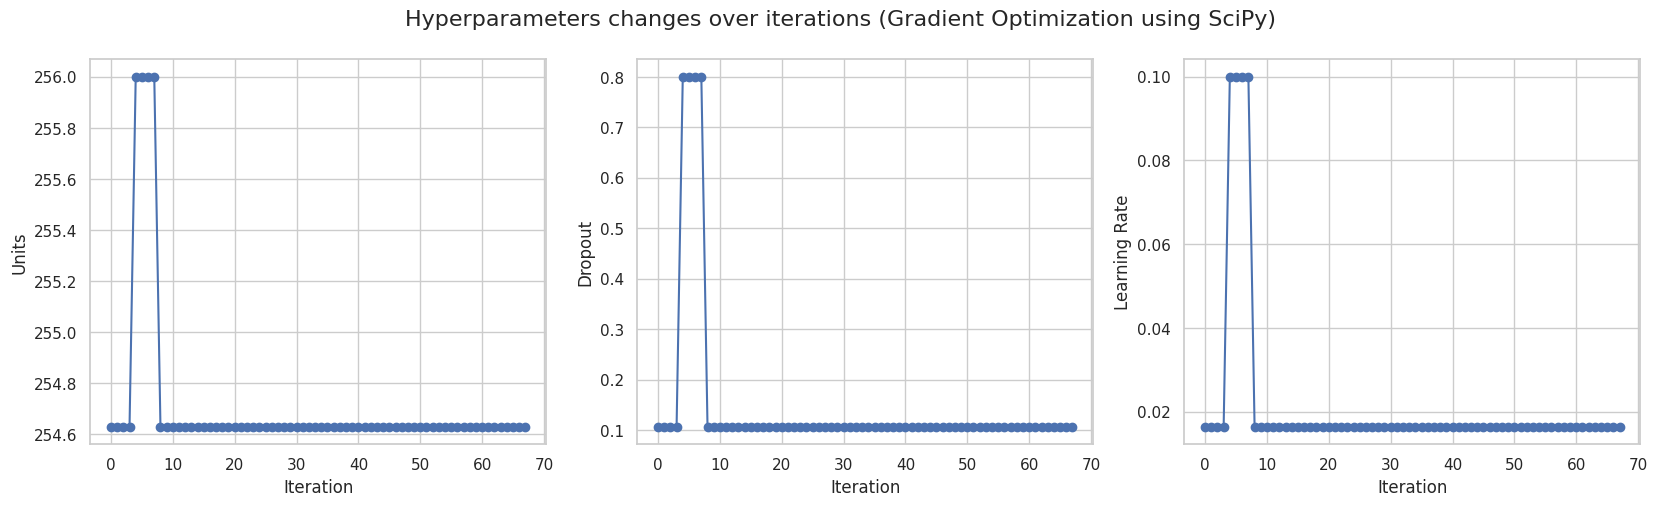

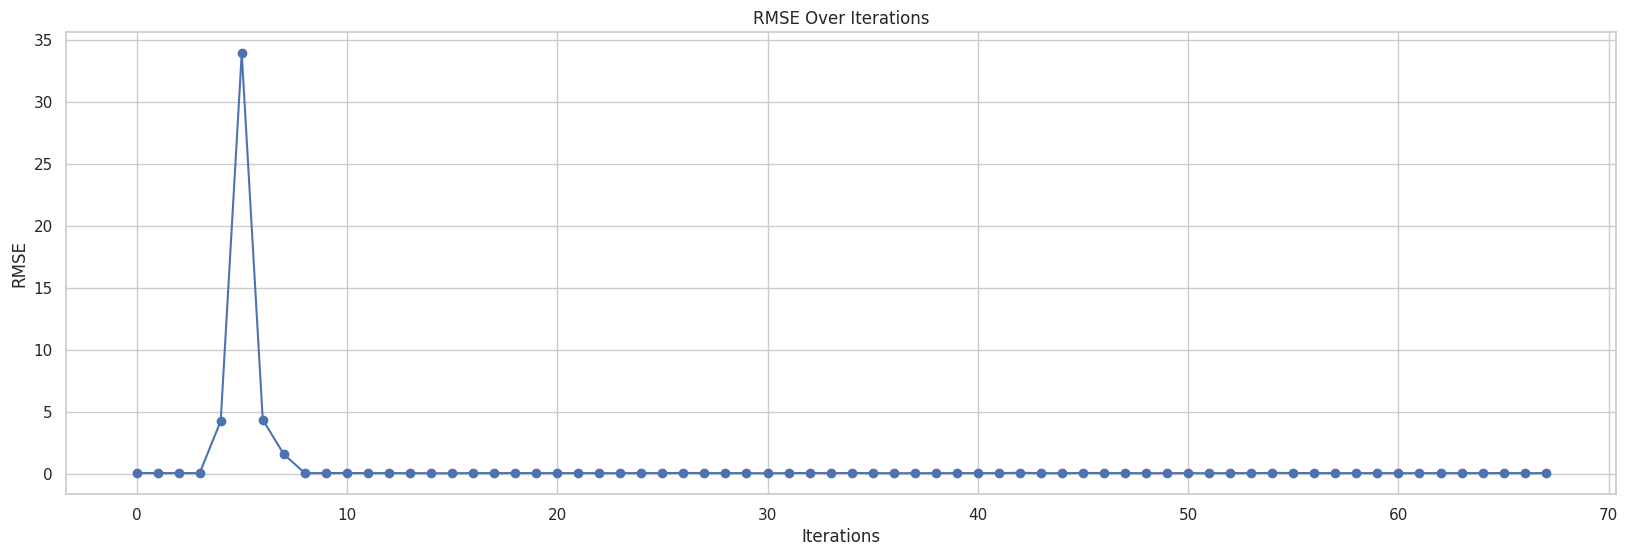

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set default style to whitegrid
sns.set(style="whitegrid")

hyperparameters_history_scipy_array = np.array(hyperparameters_history_scipy)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hyperparameters changes over iterations (Gradient Optimization using SciPy)', fontsize=16)
ax[0].plot(range(len(hyperparameters_history_scipy)), hyperparameters_history_scipy_array[:, 0], marker='o')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Units')
ax[0].grid(True)  # Ensure grid is enabled
ax[1].plot(range(len(hyperparameters_history_scipy)), hyperparameters_history_scipy_array[:, 1], marker='o')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Dropout')
ax[1].grid(True)  # Ensure grid is enabled
ax[2].plot(range(len(hyperparameters_history_scipy)), hyperparameters_history_scipy_array[:, 2], marker='o')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Learning Rate')
ax[2].grid(True)  # Ensure grid is enabled
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(range(len(mse_values_history_scipy)), mse_values_history_scipy, marker='o')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE Over Iterations')
plt.grid(True)  # Ensure grid is enabled
plt.show()


# Code for Optimization Visualisation

We Use 2 Hyperparameters (To plot on x and y axis) and output on z-axis to Visualise the Optimisation Process:
- Dropout Rate
- Learning Rate

## Grid, Random and Bayesian Model Definition

In [ ]:
def traditional_optimisation_model(dropout, learning_rate):

    np.random.seed(42)

    model = Sequential([
        LSTM(64, input_shape=(look_back, 1), activation='relu'),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

class LSTMRegressor(BaseEstimator):
    def __init__(self, dropout=0.2, learning_rate=0.01, epochs=10, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        model = traditional_optimisation_model(self.dropout, self.learning_rate)
        model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        self.model = model

    def predict(self, X):
        return self.model.predict(X, verbose=0)

def objective_function_grid(dropout, learning_rate):
    model = traditional_optimisation_model(dropout=dropout, learning_rate=learning_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    test_predict = model.predict(X_test, verbose=0)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

    return test_rmse

## Grid, Random and Bayesian Optimization Meshgrid Initialisation

In [ ]:
dropout_range = np.linspace(0, 0.99, 15)
learning_rate_range = np.linspace(0.001, 0.1, 15)
X, Y = np.meshgrid(dropout_range, learning_rate_range)

Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = objective_function_grid(X[i, j], Y[i, j])


## Grid Search

In [ ]:
param_grid = {
    'dropout': [0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid_start_time = time .time()
grid_search = GridSearchCV(LSTMRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
grid_end_time = time.time()

grid_search_time = grid_end_time - grid_start_time

In [ ]:
best_params_grid = grid_search.best_params_
optimized_model_grid = traditional_optimisation_model(**best_params_grid)
optimized_model_grid.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

train_predict_grid = optimized_model_grid.predict(X_train)
test_predict_grid = optimized_model_grid.predict(X_test)
test_rmse_grid = np.sqrt(mean_squared_error(y_test, test_predict_grid))
r2_test_grid = r2_score(y_test, test_predict_grid)

hyperparameters_history_grid = grid_search.cv_results_['params']
hyperparameter_names_grid = list(hyperparameters_history_grid[0].keys())
mse_values_grid = -grid_search.cv_results_['mean_test_score']

print("\n")
print('Best LSTM model with Grid Search')
print('Test RMSE: {:.4f}'.format(test_rmse_grid))
print('Test R2: {:.4f}'.format(r2_test_grid))

print("\n")
print('Best Hyperparameters:')
print('Dropout: {}'.format(best_params_grid['dropout']))
print('Learning Rate: {}'.format(best_params_grid['learning_rate']))


5/5 [==============================] - 0s 3ms/step


Best LSTM model with Grid Search
Test RMSE: 0.0420
Test R2: 0.7683


Best Hyperparameters:
Dropout: 0
Learning Rate: 0.01


In [ ]:
print(hyperparameters_history_grid)
print(mse_values_grid)
print('\n')
print(len(hyperparameters_history_grid))
print(len(mse_values_grid))

[{'dropout': 0, 'learning_rate': 0.001}, {'dropout': 0, 'learning_rate': 0.01}, {'dropout': 0, 'learning_rate': 0.1}, {'dropout': 0.2, 'learning_rate': 0.001}, {'dropout': 0.2, 'learning_rate': 0.01}, {'dropout': 0.2, 'learning_rate': 0.1}, {'dropout': 0.5, 'learning_rate': 0.001}, {'dropout': 0.5, 'learning_rate': 0.01}, {'dropout': 0.5, 'learning_rate': 0.1}, {'dropout': 0.8, 'learning_rate': 0.001}, {'dropout': 0.8, 'learning_rate': 0.01}, {'dropout': 0.8, 'learning_rate': 0.1}]
[0.0053635  0.0038318  0.00551287 0.00455733 0.00555862 0.01412048
 0.00608128 0.01252577 0.06317564 0.01159843 0.041339   0.16524116]


12
12


In [ ]:
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure()
fig.update_layout(width=1500, height=800)
# Add the surface plot
fig.add_trace(go.Surface(x=dropout_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))

# Add the trajectory points if the history is not empty
if hyperparameters_history_grid:
    # Add the trajectory points
    fig.add_trace(go.Scatter3d(x=[p['dropout'] for p in hyperparameters_history_grid],
                               y=[p['learning_rate'] for p in hyperparameters_history_grid],
                               z=mse_values_grid,
                               mode='markers+lines',
                               marker=dict(color='red', size=5),
                               line=dict(width=5, color='red'),
                               name='Optimization Trajectory'))

# Update layout properties
fig.update_layout(title='3D Surface of RMSE with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='RMSE'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98,  # Adjust these values to change legend position
                              orientation='h',  # Use 'v' for vertical orientation
                              traceorder='normal',  # Adjust trace order as needed
                              bordercolor='gray', borderwidth=1, bgcolor='white'))

# Show the interactive 3D plot
fig.show()


## Random Search

In [ ]:
param_distributions = {
    'dropout': [0, 0.2, 0.5, 0.8],
    'learning_rate': [0.001, 0.01, 0.1]
}

random_start_time = time.time()
random_search = RandomizedSearchCV(LSTMRegressor(), param_distributions, cv=3, scoring='neg_mean_squared_error', verbose=0)
random_search.fit(X_train, y_train)
random_end_time = time.time()

random_search_time = random_end_time - random_start_time

In [ ]:
keras.utils.set_random_seed(42)

best_params_random = random_search.best_params_
optimized_model_random = traditional_optimisation_model(**best_params_random)
optimized_model_random.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

train_predict_random = optimized_model_random.predict(X_train)
test_predict_random = optimized_model_random.predict(X_test)

train_rmse_random = np.sqrt(mean_squared_error(y_train, train_predict_random))
test_rmse_random = np.sqrt(mean_squared_error(y_test, test_predict_random))
r2_train_random = r2_score(y_train, train_predict_random)
r2_test_random = r2_score(y_test, test_predict_random)

hyperparameters_history_random = random_search.cv_results_['params']
hyperparameter_names_random = list(hyperparameters_history_random[0].keys())
mse_values_random = -random_search.cv_results_['mean_test_score']

print("\n")
print('Best LSTM model with Random Search')
print('Test RMSE: {:.4f}'.format(test_rmse_random))
print('Test R2: {:.4f}'.format(r2_test_random))

print("\n")
print('Best Hyperparameters:')
print('Dropout: {}'.format(best_params_random['dropout']))
print('Learning Rate: {}'.format(best_params_random['learning_rate']))


5/5 [==============================] - 0s 8ms/step


Best LSTM model with Random Search
Test RMSE: 0.0407
Test R2: 0.7820


Best Hyperparameters:
Dropout: 0
Learning Rate: 0.01


In [ ]:
fig = go.Figure()
fig.update_layout(width=1500, height=800)
fig.update_layout(
    margin=dict(l=80, r=80, t=80, b=80),
)
fig.add_trace(go.Surface(x=dropout_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))
if hyperparameters_history_grid:
    fig.add_trace(go.Scatter3d(x=[p['dropout'] for p in hyperparameters_history_random],
                               y=[p['learning_rate'] for p in hyperparameters_history_random],
                               z=mse_values_grid,
                               mode='markers+lines',
                               marker=dict(color='red', size=5),
                               line=dict(width=5, color='red'),
                               name='Optimization Trajectory'))

fig.update_layout(title='3D Surface of RMSE with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='RMSE'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98,
                              orientation='h',
                              traceorder='normal',
                              bordercolor='gray', borderwidth=1, bgcolor='white'))
fig.show()

## Bayesian Optimisation

In [ ]:
param_space = {
    'dropout': Real(0, 0.8),
    'learning_rate': Real(0.001, 0.1)
}

# Initialize BayesSearchCV
bayes_search_sk = BayesSearchCV(
    LSTMRegressor(),
    param_space,
    random_state=42,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs = -1
)

start_time_bayssk = time.time()
bayes_search_sk.fit(X_train, y_train)
end_time_bayssk = time.time()

bayesian_opt_time_sk = end_time_bayssk - start_time_bayssk

In [ ]:
best_hyperparameters_bayssk = bayes_search_sk.best_params_
best_dropout = best_hyperparameters_bayssk['dropout']
best_learning_rate = best_hyperparameters_bayssk['learning_rate']

best_model = traditional_optimisation_model(best_dropout, best_learning_rate)
best_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

test_rmse_sk = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test_bayes_sk = r2_score(y_test, y_pred_test)

hyperparameters_history_bayesian_sk = []
mse_history_bayesian_sk = []

results_bayesian_sk = bayes_search_sk.cv_results_
param_names_bayesian_sk = list(param_space.keys())

for i, params in enumerate(results_bayesian_sk['params']):
    hyperparameters = [params[param_name] for param_name in param_names_bayesian_sk]
    mts = results_bayesian_sk['mean_test_score'][i]
    hyperparameters_history_bayesian_sk.append(hyperparameters)
    mse_history_bayesian_sk.append(-mts)

print('Best LSTM model with Bayesian Optimization (using skopt)')
print('Test RMSE: {:.4f}'.format(test_rmse_sk))
print('Test R2: {:.4f}'.format(r2_test_bayes_sk))
print("\n")
print('Best Hyperparameters:')
print('Dropout: {}'.format(best_dropout))
print('Learning Rate: {}'.format(best_learning_rate))

5/5 [==============================] - 0s 7ms/step
Best LSTM model with Bayesian Optimization (using skopt)
Test RMSE: 0.0379
Test R2: 0.8106


Best Hyperparameters:
Dropout: 0.0
Learning Rate: 0.09532466250482416


In [ ]:
fig = go.Figure()
fig.update_layout(width=1500, height=800)
fig.update_layout(
    margin=dict(l=80, r=80, t=80, b=80),
)
fig.add_trace(go.Surface(x=dropout_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))
fig.add_trace(go.Scatter3d(x=[p[0] for p in hyperparameters_history_bayesian_sk],
                           y=[p[1] for p in hyperparameters_history_bayesian_sk],
                           z=mse_history_bayesian_sk,
                           mode='markers+lines',
                           marker=dict(color='red', size=5),
                           line=dict(width=5, color='red'),
                           name='Optimization Trajectory'))
fig.update_layout(title='3D Surface of RMSE with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='RMSE'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98,
                              orientation='h',
                              traceorder='normal',
                              bordercolor='gray', borderwidth=1, bgcolor='white'))
fig.show()


## Gradient-based Optimisation

#### Objective Function Definition

In [ ]:
def gradient_optimisation_model(dropout, learning_rate):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=(look_back, 1), activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

hyperparameters_history_scipy = []
mse_values_history_scipy = []
training_time_history = []

def objective_function(params):
    dropout, learning_rate = params

    #add early stopping for regression model
    early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=0, mode='auto', restore_best_weights=True)

    start_time_scipy = time.time()
    model = gradient_optimisation_model(dropout, learning_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, callbacks=[early_stopping])
    end_time_scipy = time.time()

    training_time_scipy = end_time_scipy - start_time_scipy

    test_predict = model.predict(X_test, verbose=0)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

    hyperparameters_history_scipy.append(params)
    mse_values_history_scipy.append(test_rmse)
    training_time_history.append(training_time_scipy)
    return test_rmse

#### Performing Gradient Based Optimisation

In [ ]:
initial_params = [0.4, 0.001]
bounds = [(0, 0.8), (0.001, 0.1)]

trajectory = [initial_params.copy()]

def track_trajectory(x):
    trajectory.append(x.copy())

minimize_start_time = time.time()
result = minimize(objective_function, initial_params, method='L-BFGS-B',
                  options={'disp': True}, bounds=bounds,
                  callback=track_trajectory)
minimize_end_time = time.time()

minimize_time = minimize_end_time - minimize_start_time

# Calculate RMSE for each point in the trajectory
rmse_values_trajectory = [objective_function(point) for point in trajectory]

In [ ]:
keras.utils.set_random_seed(42)

best_params_scipy = result.x
best_dropout_scipy, best_learning_rate_scipy = best_params_scipy

optimized_model_scipy = gradient_optimisation_model(best_dropout_scipy, best_learning_rate_scipy)
optimized_model_scipy.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

train_predict_scipy = optimized_model_scipy.predict(X_train)
test_predict_scipy = optimized_model_scipy.predict(X_test)

test_rmse_scipy = np.sqrt(mean_squared_error(y_test, test_predict_scipy))
r2_train_scipy = r2_score(y_train, train_predict_scipy)
r2_test_scipy = r2_score(y_test, test_predict_scipy)

# Print model statistics and plot the predictions vs. actual values for the best model
print("\n")
print('Best LSTM model')
print('Test RMSE: {:.4f}'.format(test_rmse_scipy))
print('Train R2: {:.4f}'.format(r2_train_scipy))
print('Test R2: {:.4f}'.format(r2_test_scipy))

# Print the best hyperparameters with a space between each hyperparameter and output above and below
print("\n")
print('Best Hyperparameters:')
print('Dropout: {}'.format(round(best_dropout_scipy, 4)))
print('Batch Size: {}'.format(best_learning_rate_scipy))

5/5 [==============================] - 0s 3ms/step


Best LSTM model
Test RMSE: 0.0502
Train R2: 0.9734
Test R2: 0.6685


Best Hyperparameters:
Dropout: 0.4
Batch Size: 0.0010013092866373858


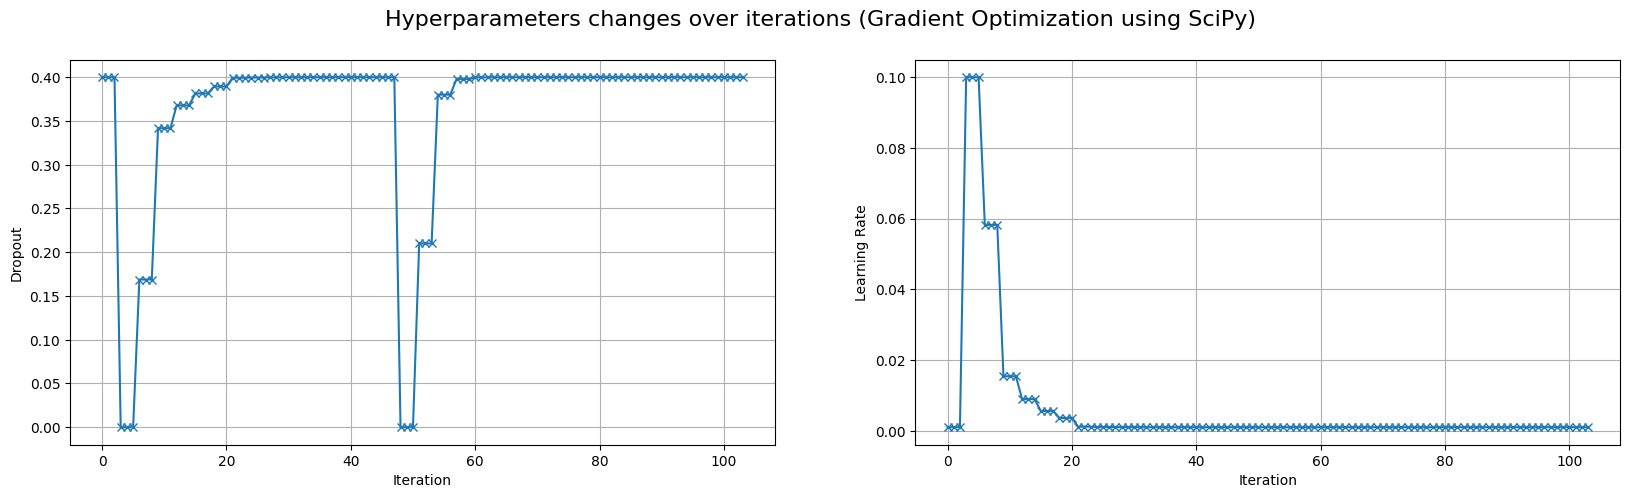

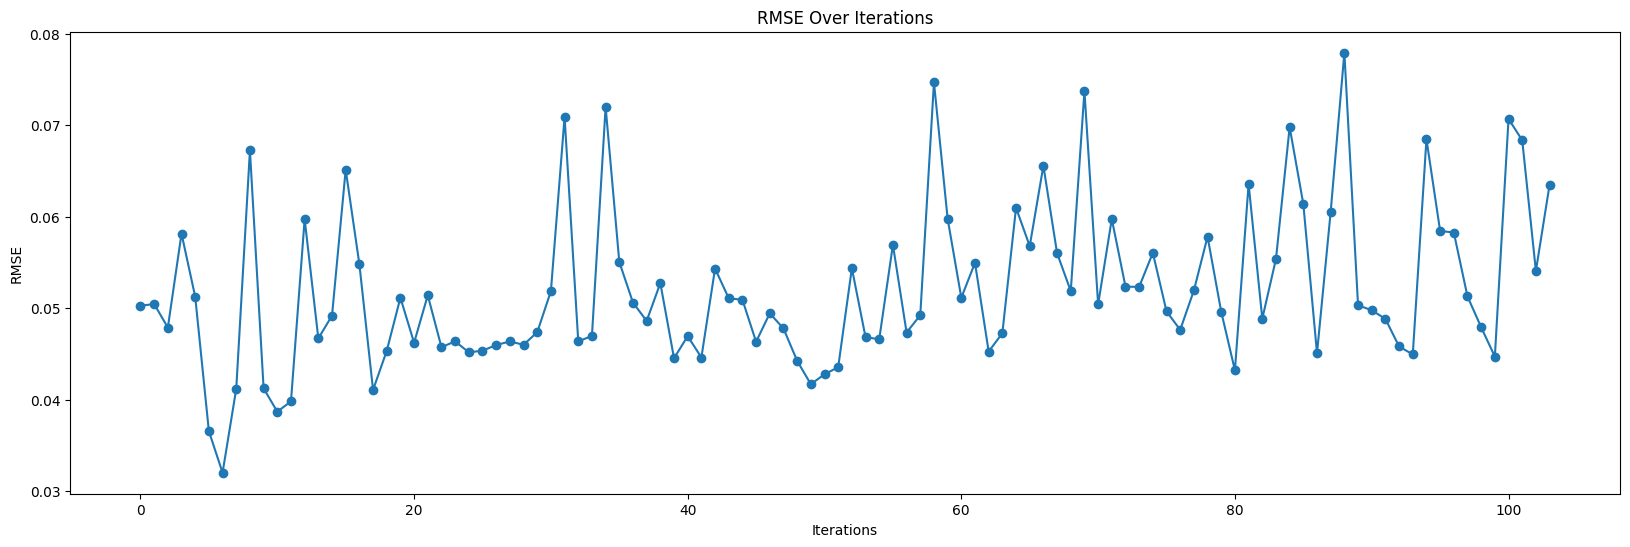

In [ ]:
hyperparameters_history_scipy_array = np.array(hyperparameters_history_scipy)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Hyperparameters changes over iterations (Gradient Optimization using SciPy)', fontsize=16)
ax[0].plot(hyperparameters_history_scipy_array[:, 0], marker='x')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Dropout')
ax[0].grid()
ax[1].plot(hyperparameters_history_scipy_array[:, 1], marker='x')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Learning Rate')
ax[1].grid()
plt.show()


plt.figure(figsize=(20, 6))
plt.plot(range(len(mse_values_history_scipy)), mse_values_history_scipy, marker='o')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE Over Iterations')
plt.show()

In [ ]:
print(hyperparameters_history_scipy_array)
print(mse_values_history_scipy)

[[4.00000000e-01 1.00000000e-03]
 [4.00000010e-01 1.00000000e-03]
 [4.00000000e-01 1.00001000e-03]
 [0.00000000e+00 1.00000000e-01]
 [1.00000000e-08 1.00000000e-01]
 [0.00000000e+00 9.99999900e-02]
 [1.68811729e-01 5.82190972e-02]
 [1.68811739e-01 5.82190972e-02]
 [1.68811729e-01 5.82191072e-02]
 [3.41744723e-01 1.54181810e-02]
 [3.41744733e-01 1.54181810e-02]
 [3.41744723e-01 1.54181910e-02]
 [3.67863581e-01 8.95376378e-03]
 [3.67863591e-01 8.95376378e-03]
 [3.67863581e-01 8.95377378e-03]
 [3.81456564e-01 5.58950046e-03]
 [3.81456574e-01 5.58950046e-03]
 [3.81456564e-01 5.58951046e-03]
 [3.89468417e-01 3.60656686e-03]
 [3.89468427e-01 3.60656686e-03]
 [3.89468417e-01 3.60657686e-03]
 [3.99379675e-01 1.15353050e-03]
 [3.99379685e-01 1.15353050e-03]
 [3.99379675e-01 1.15354050e-03]
 [3.99647555e-01 1.08723026e-03]
 [3.99647565e-01 1.08723026e-03]
 [3.99647555e-01 1.08724026e-03]
 [3.99880993e-01 1.02945428e-03]
 [3.99881003e-01 1.02945428e-03]
 [3.99880993e-01 1.02946428e-03]
 [3.999440

#### Defining the Meshgrid and Plotting the Results for Gradient Based Optimisation

In [ ]:
dropout_range = np.linspace(0, 0.99, 15)
learning_rate_range = np.linspace(0.001, 0.1, 15)
X, Y = np.meshgrid(dropout_range, learning_rate_range)

Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = objective_function([X[i, j], Y[i, j]])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(width=1500, height=800)
fig.update_layout(
    margin=dict(l=80, r=80, t=80, b=80),)
fig.add_trace(go.Surface(x=dropout_range, y=learning_rate_range, z=Z, colorscale='Viridis', colorbar=dict(title='RMSE')))
fig.add_trace(go.Scatter3d(x=[p[0] for p in trajectory], y=[p[1] for p in trajectory],
                           z=rmse_values_trajectory, mode='markers+lines',
                           marker=dict(color='red', size=5),
                           line=dict(width=5, color='red'),
                           name='Optimization Trajectory'))
for i in range(1, len(trajectory)):
    x_start, y_start, z_start = trajectory[i][0], trajectory[i][1], rmse_values_trajectory[i]
    x_end, y_end, z_end = trajectory[i-1][0], trajectory[i-1][1], rmse_values_trajectory[i-1]

    fig.add_trace(go.Scatter3d(x=[trajectory[0][0]], y=[trajectory[0][1]],
                           z=[rmse_values_trajectory[0]],
                           mode='markers', marker=dict(color='blue', size=6),
                           name='Initial Point'))

    fig.add_trace(go.Cone(x=[x_end], y=[y_end], z=[z_end - 0.01],
                          u=[x_start - x_end], v=[y_start - y_end], w=[z_start - z_end],
                          sizemode="absolute", sizeref=0.03, showscale=False))

fig.update_layout(title='3D Surface of RMSE with Optimization Trajectory',
                  scene=dict(xaxis_title='Dropout', yaxis_title='Learning Rate', zaxis_title='RMSE'),
                  showlegend=True,
                  legend=dict(x=0.01, y=0.98, # Adjust these values to change legend position
                                 orientation='h',  # Use 'v' for vertical orientation
                                 traceorder='normal',  # Adjust trace order as needed
                                 bordercolor='gray', borderwidth=1, bgcolor='white'))
fig.show()

#convert the 3d plot to 2d plot

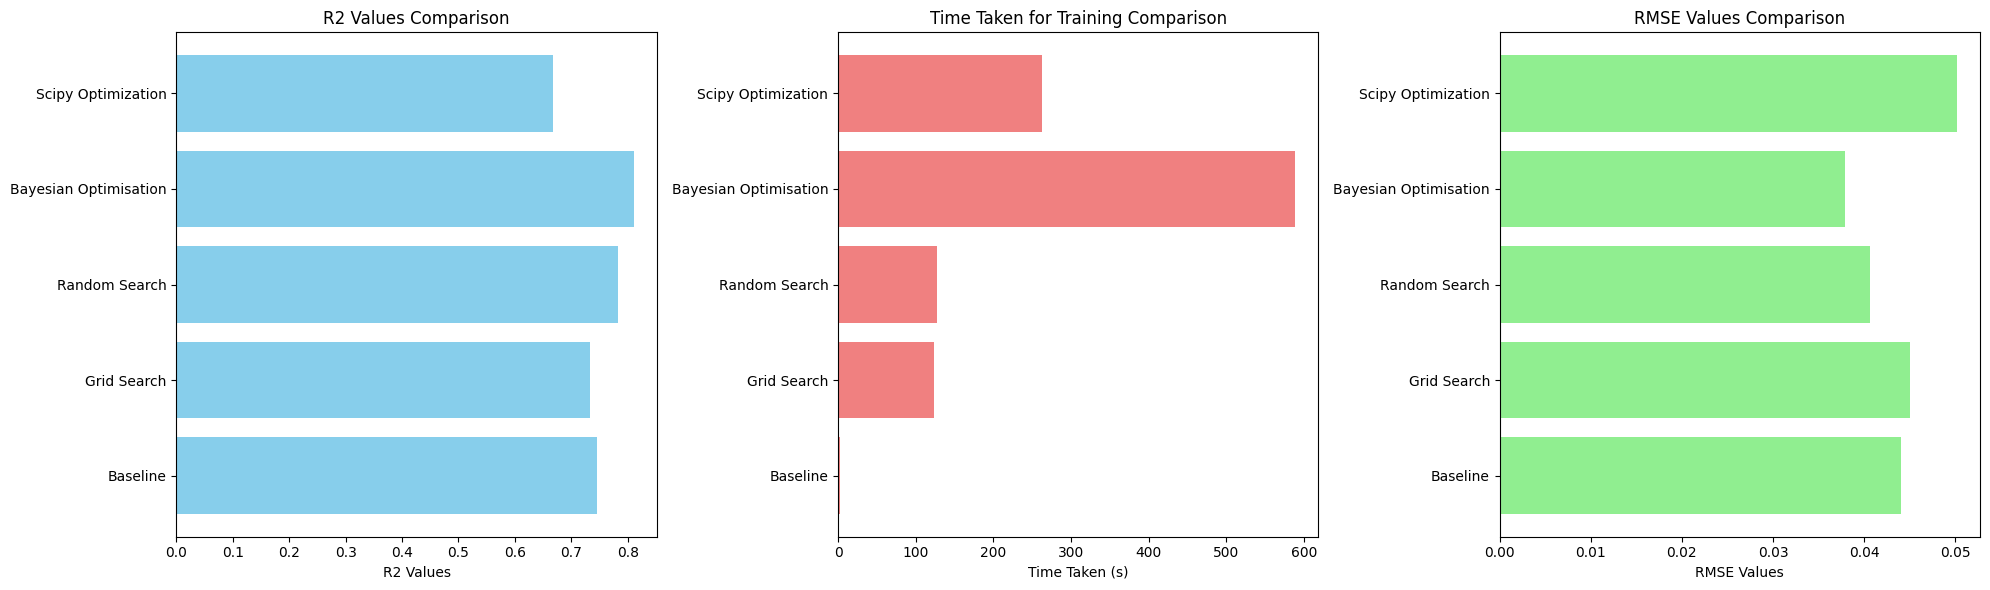

In [ ]:
methods = ['Baseline', 'Grid Search', 'Random Search', 'Bayesian Optimisation', 'Scipy Optimization']

r2_values = [r2_test_baseline, r2_test_grid, r2_test_random, r2_test_bayes_sk, r2_test_scipy]
rmse_values = [test_rmse_baseline, test_rmse_grid, test_rmse_random, test_rmse_sk, test_rmse_scipy]
time_taken = [baseline_time, grid_search_time, random_search_time, bayesian_opt_time_sk, minimize_time]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.barh(methods, r2_values, color='skyblue')
ax1.set_xlabel('R2 Values')
ax1.set_title('R2 Values Comparison')

ax2.barh(methods, time_taken, color='lightcoral')
ax2.set_xlabel('Time Taken (s)')
ax2.set_title('Time Taken for Training Comparison')

ax3.barh(methods, rmse_values, color='lightgreen')
ax3.set_xlabel('RMSE Values')
ax3.set_title('RMSE Values Comparison')

plt.tight_layout()
plt.show()
